In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal
from math import floor

# Input parameters

In [2]:
YorN = "Z"
while YorN != "Y" and YorN != "N": 
    YorN = str(input("Use default parameters ? Y (yes) / N (no): "))

if YorN == "Y":
    us_field = 0.5

    us_ch = -1

    us_mass = 0.511

    us_momentum = 2

    us_angle = 0

###################################################################################################

if YorN == "N":

    us_field = float(input("Enter the component of the magnetic field along the z axis (in T): "))

    us_ch = float(input("Enter the charge of the particle (in elementary charge, i.e = -1 for an electron): "))

    us_mass = -1
    while us_mass < 0:
        us_mass = float(input("Enter the mass of the particle (in MeV/c²), must be positive: "))

    us_momentum = -1
    while us_momentum < 0:
        us_momentum = float(input("Enter the average momentum of the particle (in MeV/c), must be positive: "))


    us_angle = float(input("Enter the initial opening angle of the particle beam (in rad): "))

Use default parameters ? Y (yes) / N (no): Y


# Classes definition

In [3]:
# To define once physical constants used a lot in the program

class Constant: 
    def __init__(self):
        self.c = 3.0 * 10 ** 8 # speed of light m/s
        self.pi = np.pi
        self.q = 1.609 * 10 ** (-19) # elementary electric charge in Coulomb

cst = Constant()

In [4]:
# Defines the 4 detectors (properties, positions)

class Detector: 
    def __init__(self):
        
        # Constants for Beth & Bloch formula

        self.rho = 2.2 # g/cm^3
        self.thickness = 14 * 10 ** (-4) # thickness in cm
        self.x = self.rho * self.thickness # g/cm²  
        self.X0 = 27.05 # g/cm² silicon radiation length
        self.ZsurA = 0.49930 # Z / A of silicon
        self.K = 0.3070755629 # MeV cm² / mol
        self.Z = 14 # Z of silicon
        self.I = 9.76 + 58.8 * self.Z ** (-1.19) # eV
        self.j = 0.2
        self.w = 3.6 # eV

        # Positions of detectors

        self.position = np.array([18, 12, -12, -18],float) * 10 ** (-3) # On x-axis, in m

        # The ksi on Beth and Block formula : ksi = ksi(beta) = ksi(beta(E))

    def ksi(self, beta):
        return (self.K * self.ZsurA * self.x ) / (2 * beta ** 2)

detector = Detector()

In [5]:
# Defines the magnetic field

class Field: 
    def __init__(self, norm):
        self.norm = norm # Norm of the field, in T
        self.B = np.array([0, 0, self.norm],float) # Along the z-axis
        
        # Field zone

        self.xmin = -0.005 #m
        self.xmax = 0.005 #m
        self.ymin = -0.010 #m
        self.ymax = 0.010 #m

        self.L = self.xmax - self.xmin

field = Field(us_field)

In [6]:
class Particle:
    def __init__(self, mass, p, q, opening_angle): 
        
        # Properties in MeV (mass, momentum and energy)
        
        self.mass = mass # MeV / c²
        self.p = p # MeV / c
        self.E = np.sqrt(self.p ** 2 + self.mass ** 2) # MeV

        # Relativistic parameters

        self.gamma = self.E / self.mass
        self.beta = self.p / self.E

        # Conversion in international units (charge, initial angle, mass, momentum)

        self.q = q   
        self.opening_angle = opening_angle #rad
        self.mass_si = self.mass * 10 ** 6 * 1.609 * 10 ** (-19) / (cst.c ** 2) # kg
        self.p_si = self.p * 1.609 * 10 ** (-19) * 10 ** 6 / cst.c # kg*m/s
        self.v_si = self.p_si / (self.gamma * self.mass_si) # m/s   

        # Position and speed vectors

        self.r = np.array([0.030, 0.005, 0],float)
        self.v = self.v_si * np.array([- np.cos(self.opening_angle) , np.sin(self.opening_angle), 0],float) 

        # Time step (s) 
        
        self.h = 10 ** (-12)

        # List of list of position to plot trajectories
               
        self.position = [[self.r[0]],[self.r[1]],[self.r[2]]]   

##### Scatter function : Scatters the particle when it reaches a detector 
##### Is a function of detector class
##### Possibility to fix the seed to have the same scattering effect with True_or_False = True
##### False : Random deviation every time

    def scatter(self, detecteur, True_or_False):     
        d = detecteur
        # Standard deviation of the angle distribution
        self.theta0 = ((13.6) / (self.p * self.beta)) * abs(us_ch) * np.sqrt(d.x / d.X0) * (1 + 0.038 * np.log(d.x / d.X0)) 
        if True_or_False == 1:
            np.random.seed(2)
        angle = np.random.normal(0, self.theta0)
        # Rotates the speed vector
        rot = np.array([[np.cos(angle),-np.sin(angle),0],
                        [np.sin(angle),np.cos(angle),0],
                        [0,0,1]])
        self.v = np.matmul(rot, self.v) 
        np.random.seed() # Resets the seed

##### "depot_impulsion" function : gives a part of energy to the detector and returns that part of energy loss
##### Modifies particle characteristics after the detector (energy, speed ...)
##### Is a function of detector class 

    def depot_impulsion(self, detecteur): # MeV/c, according to a Landau distribution
        d = detecteur
        ksi = d.ksi(self.beta)
        # Most probable value of energy loss :
        self.Deltap = ksi * (np.log((2 * self.mass * 10 ** 6 * (self.beta * self.gamma) ** 2) / d.I) + np.log (ksi * 10 ** 6 / d.I) + d.j - self.beta ** 2)
        # Width of the Landau distribution
        self.w = 4.018 * ksi 

        p_deposee = -1 # Begins with negative deposition 
        # Assigns energy loss until it is positive and smaller than the whole momentum
        while p_deposee < 0 or p_deposee > self.p : 
            p_deposee = moyal.rvs(loc = self.Deltap, scale = self.w, size = 1)[0]

        self.p -= p_deposee # Substracts the momentum loss

        # New characteristics after energy loss
        self.E = np.sqrt(self.p ** 2 + self.mass ** 2) 
        self.gamma = self.E / self.mass
        self.beta = self.p / self.E
        self.p_si = self.p * 1.609 * 10 ** (-19) * 10 ** 6 / cst.c # kg*m/s
        self.v_si = self.p_si / (self.gamma * self.mass_si) # m/s
        self.v = (self.v / np.linalg.norm(self.v)) * self.v_si
        return p_deposee
    
##### Traj function : Computes the particle trajectory and take into account the detectors effects  
##### Breaks if the particle turned around

    def traj(self, detecteur, champ, scatter_or_not, seed_or_not, energy_loss_or_not): 
    # 1 : with effect. 0 : without effect (scatter, seed and energy)
        self.detection = [[],[]] # first row : x detection. second row : y detection
        d = detecteur
        B = champ
        self.t_field = 0 # Time spent in the magnetic field (s)
        def move_without_field(): # Trajectory of free particle (without magnetic field)
            self.r[0] += self.v[0] * self.h 
            self.r[1] += self.v[1] * self.h 
        def move_with_field(x0, y0, vx0, vy0, w): # Trajectory in presence of the magnetic field
            self.r[0] = (vx0 / w) * np.sin(w * self.t_field) - (vy0 / w) * np.cos(w * self.t_field) + x0 + vy0 / w
            self.r[1] = (vy0 / w) * np.sin(w * self.t_field) + (vx0 / w) * np.cos(w * self.t_field) + y0 - vx0 / w
            self.v[0] = vx0 * np.cos(w * self.t_field) + vy0 * np.sin(w * self.t_field)
            self.v[1] = vy0 * np.cos(w * self.t_field) - vx0 * np.sin(w * self.t_field)
            self.t_field += self.h 
        def append_coord(): # Appends the coordinates into the list for the plots
            for i in range(0,3):
                    self.position[i].append(self.r[i])

        entering_field = 1 # Put to 1 and is turned to 0 when the particle enters the field

        # Goes from 0 to the number of detectors (4)
        for j in range (0, len(d.position)): 
            # While the particle has not yet reached the j-th detector
            while (self.r[0] > d.position[j]): 
                # Checks if the particle is in the field
                if self.r[0] > B.xmin and self.r[0] < B.xmax and self.r[1] > B.ymin and self.r[1] < B.ymax : 
                    if entering_field == 1: # Happens only once, when the particle enters the field
                        x0_field = self.r[0]
                        y0_field = self.r[1]
                        vx0_field = self.v[0]
                        vy0_field = self.v[1]
                        w = (self.q * B.norm) / (self.gamma * self.mass_si)
                        entering_field = 0
                   # Makes the particle move in presence of the field
                    move_with_field(x0_field, y0_field, vx0_field, vy0_field, w) 
                else : 
                    move_without_field() # Makes the particle move without field
                append_coord() # Appends the coordinates in the list for the plots
                if self.position[0][-2] < self.position[0][-1]: # If the particle turned around : break
                    break
            if self.r[0] <= d.position[j] : # If the particle has passed the detector
                if scatter_or_not == 1: # If we want the scattering effect
                    self.scatter(d, seed_or_not) # Scatters the particle
                if energy_loss_or_not == 1: # If we want energy loss
                    # If the energy loss is enough to activate the detector
                    if (self.depot_impulsion(detecteur) * 10 ** 6) / detector.w > 100: 
                        # Mean value of the last 2 positions (in x and y)
                        self.detection[0].append((self.position[0][-2] + self.position[0][-1]) / 2) 
                        self.detection[1].append((self.position[1][-2] + self.position[1][-1]) / 2)
                else : # If we don't want energy loss, detects the particle anyway
                    # Mean value of the last 2 positions (in x and y)
                    self.detection[0].append((self.position[0][-2] + self.position[0][-1]) / 2) 
                    self.detection[1].append((self.position[1][-2] + self.position[1][-1]) / 2)

##### Detection check function : returns 1 if the particle has activated the 4 detectors, else returns 0

    def detection_check(self):
        if len(self.detection[0]) == 4:
            return 1
        else:
            return 0
        
##### "mesure_p" function : reconstructs the momentum

    def mesure_p(self, field): # Returns the reconstructed momentum
        self.angle = np.arctan2(self.detection[1][3] - self.detection[1][2], self.detection[0][3] - self.detection[0][2]) # rad 
        # Computes the angle with the detection coordinates
        self.p_mesure = abs((self.q / cst.q) * 0.3 * field.norm * field.L / np.sin(self.angle) * 10 ** 3) # MeV
        return self.p_mesure

# Graphical Results

In [7]:
# Creates 3 particles, one with perfect trajectory, the second with scattering effect, and the third with scattering effect and energy loss effect.

part1 = Particle(us_mass, us_momentum, us_ch * cst.q, us_angle)
part2 = Particle(us_mass, us_momentum, us_ch * cst.q, us_angle)
part3 = Particle(us_mass, us_momentum, us_ch * cst.q, us_angle)

# Computes the trajectories

part1.traj(detector, field, 0, 0, 0) # Without scattering and without energy loss
part2.traj(detector, field, 1, 1, 0) # With scattering and seed
part3.traj(detector, field, 1, 1, 1) # With scattering, seed, and energy loss

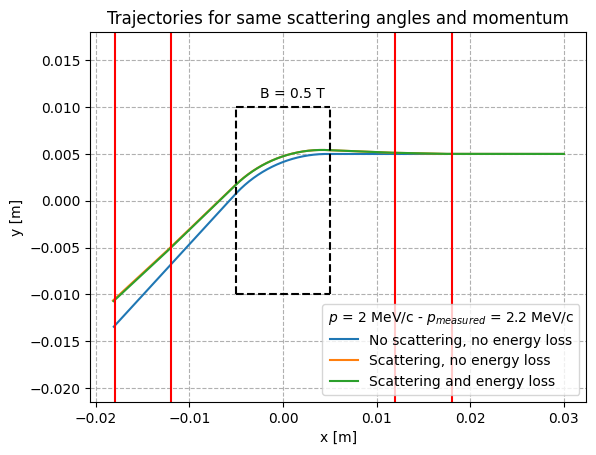

In [8]:
plt.plot(part1.position[0], part1.position[1], label = "No scattering, no energy loss")
plt.plot(part2.position[0], part2.position[1], label = "Scattering, no energy loss")
plt.plot(part3.position[0], part3.position[1], label = "Scattering and energy loss")
plt.plot([field.xmax, field.xmax], [field.ymin, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmin], [field.ymin, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmax], [field.ymax, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmax], [field.ymin, field.ymin], ls="--", c="black")
plt.axvline(x = detector.position[0], c="red")
plt.axvline(x = detector.position[1], c="red")
plt.axvline(x = detector.position[2], c="red")
plt.axvline(x = detector.position[3], c="red")
plt.annotate("B = " + str(field.norm) + " T", xy = (-0.0025, 0.011), color = 'black')
plt.title("Trajectories for same scattering angles and momentum")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.grid(ls ="--")
plt.legend(loc = "lower right", title = "$p$ = " + str(round(us_momentum, 2)) + " MeV/c - $p_{measured}$ = " + str(round(part3.mesure_p(field), 2)) + " MeV/c")
plt.savefig("Fig1.png", format = 'png', dpi = 200)
plt.show()

## Limits of reconstruction

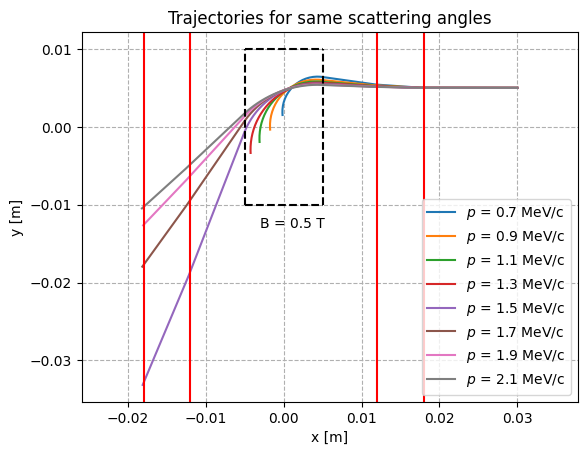

In [9]:
# Trajectories for diffent small momenta

p_min = floor(15 * us_mass)
p_max = floor(40 * us_mass)
step = floor(4 * us_mass)
for p in range(p_min, p_max + step, step):
    part = Particle(us_mass, p * 0.1, us_ch * cst.q, us_angle)
    part.traj(detector, field, 1, 1, 1)
    plt.plot(part.position[0], part.position[1], label = "$p$ = " + str(round(p * 0.1, 2)) + " MeV/c")
plt.plot([field.xmax, field.xmax], [field.ymin, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmin], [field.ymin, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmax], [field.ymax, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmax], [field.ymin, field.ymin], ls="--", c="black")
plt.axvline(x = detector.position[0], c="red")
plt.axvline(x = detector.position[1], c="red")
plt.axvline(x = detector.position[2], c="red")
plt.axvline(x = detector.position[3], c="red")
plt.annotate("B = " + str(field.norm) + " T", xy = (-0.003, -0.013), color = 'black')
plt.title("Trajectories for same scattering angles")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.grid(ls ="--")
plt.legend(loc = "lower right")
plt.savefig("Fig2.png", format = 'png', dpi = 200)
plt.show()

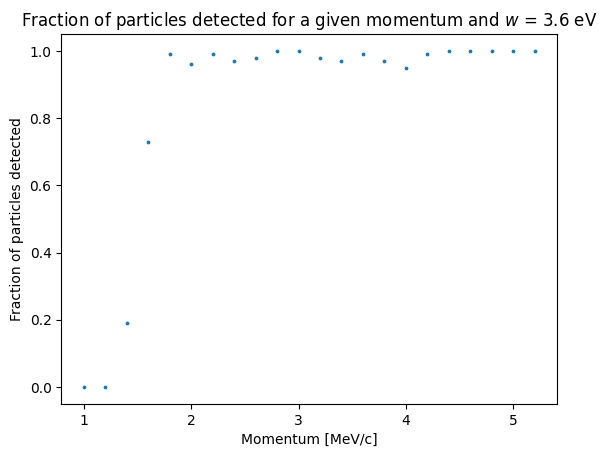

In [10]:
# Effect of energy threshold for different momenta

n = 100 # Number of particles per momentum
p_min = floor(20 * us_mass)
p_max = floor(100 * us_mass)
step = floor(4 * us_mass)
liste_p = []
liste_pourcentage_detection = []
for p in range(p_min, p_max + step, step):
    compteur_detection = 0
    for i in range(0, n):
        part = Particle(us_mass, p * 0.1, us_ch * cst.q, us_angle)
        part.traj(detector, field, 1, 0, 1)
        compteur_detection += part.detection_check() # Counting how many particles activted all 4 detectors
    liste_p.append(p / 10)
    liste_pourcentage_detection.append(compteur_detection / n)
plt.scatter(liste_p, liste_pourcentage_detection, s = 3)
plt.title("Fraction of particles detected for a given momentum and $w$ = " + str(detector.w) + " eV")
plt.xlabel("Momentum [MeV/c]")
plt.ylabel("Fraction of particles detected")
plt.savefig("Fig3.png", format = 'png', dpi = 200)
plt.show()

## Momentum reconstruction for diffrent initial distributions

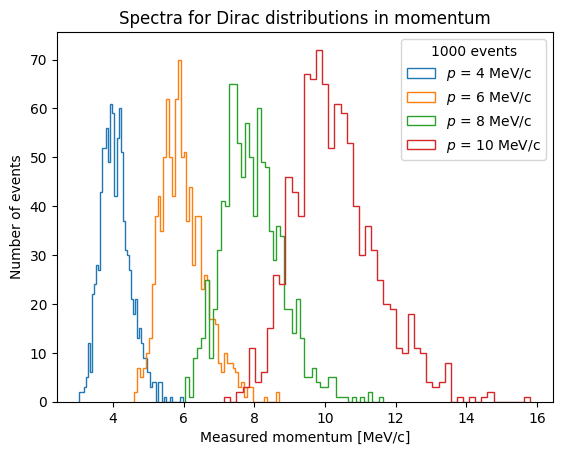

In [11]:
n = 1000 # Number of particles per momentum
p_min = floor(8 * us_mass)
p_max = floor(24 * us_mass)
for p in range(p_min, p_max, floor(p_min / 2)):
    liste_p_mesure = []
    for i in range(0, n):
        part = Particle(us_mass, p, us_ch * cst.q, us_angle)
        part.traj(detector, field, 1, 0, 1)
        if part.detection_check() == 1:
            liste_p_mesure.append(part.mesure_p(field))
    plt.hist(liste_p_mesure, histtype="step", label = "$p$ = " + str(p) + " MeV/c", bins = floor(n / 20))
plt.xlabel("Measured momentum [MeV/c]")
plt.ylabel("Number of events")
plt.title("Spectra for Dirac distributions in momentum")
plt.legend(title = str(n) + " events")
plt.savefig("Fig4.png", format = 'png', dpi = 200)
plt.show()

Measurement for a Gaussian distribution in momentum

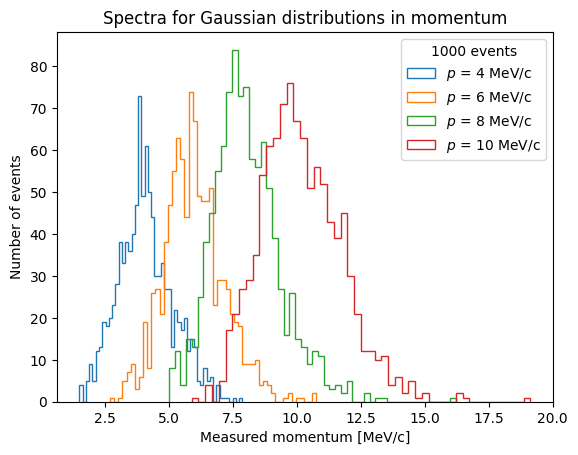

In [12]:
n = 1000 # Number of particles per momentum
p_min = floor(8 * us_mass)
p_max = floor(24 * us_mass)
for p in range(p_min, p_max, floor(p_min / 2)):
    liste_p_mesure = []
    for i in range(0, n):
        part = Particle(us_mass, p, us_ch * cst.q, us_angle)
        part.p = np.random.normal(p, p_min / 4)
        part.traj(detector, field, 1, 0, 1)
        if part.detection_check() == 1:
            liste_p_mesure.append(part.mesure_p(field))
    plt.hist(liste_p_mesure, histtype="step", label = "$p$ = " + str(p) + " MeV/c", bins = floor(n / 20))
plt.xlabel("Measured momentum [MeV/c]")
plt.ylabel("Number of events")
plt.title("Spectra for Gaussian distributions in momentum")
plt.legend(title = str(n) + " events")
plt.savefig("Fig5.png", format = 'png', dpi = 200)
plt.show()

## Effect of the opening angle

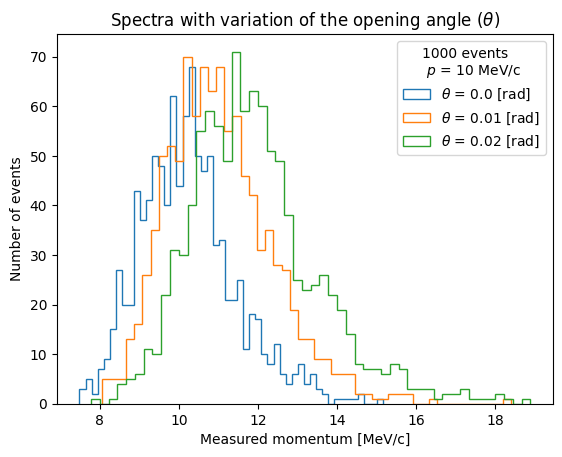

In [13]:
# Momentum reconstruction for different opening angles

n = 1000 # Number of particles per momentum
p = 5 * us_momentum
for opening_angle in range(0, 3):
    liste_p_mesure = []
    for i in range(0, n):
        part = Particle(us_mass, p, us_ch * cst.q, us_angle + opening_angle * 0.01)
        part.traj(detector, field, 1, 0, 1)
        if part.detection_check() == 1:
            liste_p_mesure.append(part.mesure_p(field))
    plt.hist(liste_p_mesure, histtype="step", label = r"$\theta$ = " + str(round(opening_angle * 0.01, 2)) + " [rad]", bins = floor(n/20))
plt.xlabel("Measured momentum [MeV/c]")
plt.ylabel("Number of events")
plt.title(r"Spectra with variation of the opening angle ($\theta$)")
plt.legend(title = str(n) + " events \n $p$ = " + str(round(p, 2)) + " MeV/c")
plt.savefig("Fig6.png", format = 'png', dpi = 200)
plt.show()

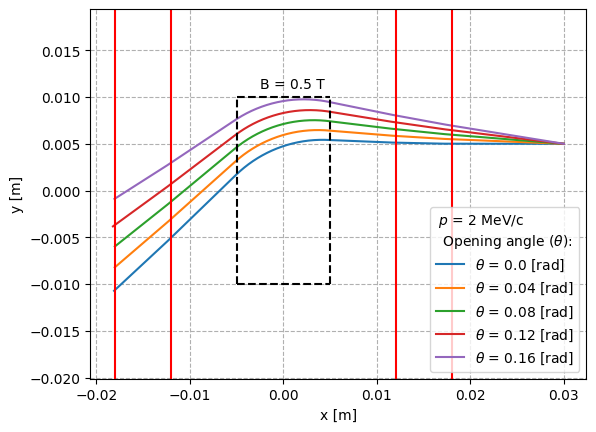

In [14]:
# Trajectories for differnet opening angles

for angle in range(0, 10, 2):
    part = Particle(us_mass, us_momentum, us_ch * cst.q, us_angle + angle * 0.02)
    part.traj(detector, field, 1, 1, 1)
    plt.plot(part.position[0], part.position[1], label = r"$\theta$ = " + str(round(angle * 0.02, 2)) + " [rad]")
plt.plot([field.xmax, field.xmax], [field.ymin, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmin], [field.ymin, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmax], [field.ymax, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmax], [field.ymin, field.ymin], ls="--", c="black")
plt.axvline(x = detector.position[0], c="red")
plt.axvline(x = detector.position[1], c="red")
plt.axvline(x = detector.position[2], c="red")
plt.axvline(x = detector.position[3], c="red")
plt.annotate("B = " + str(field.norm) + " T", xy = (-0.0025, 0.011), color = 'black')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.grid(ls ="--")
plt.legend(loc = "lower right", title = "$p$ = " + str(us_momentum) + " MeV/c \n Opening angle" + r" ($\theta$):")
plt.savefig("Fig7.png", format = 'png', dpi = 200)
plt.show()

## Impact of scattering for different momenta

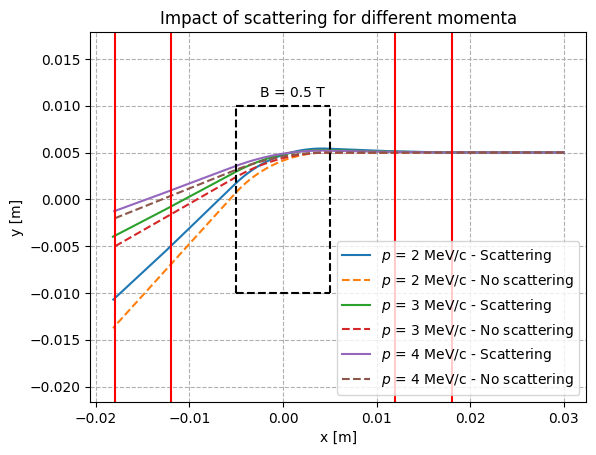

In [15]:
# Scattered and non-scattered trajectories for different momenta

p_min = floor(4 * us_mass)
p_max = floor(10 * us_mass)
step = floor(2 * us_mass)
for p in range(p_min, p_max, step):
    part = Particle(us_mass, p, us_ch * cst.q, us_angle)
    part2 = Particle(us_mass, p, us_ch * cst.q, us_angle)
    part.traj(detector, field, 1, 1, 1)
    part2.traj(detector, field, 0, 0, 1)
    plt.plot(part.position[0], part.position[1], label = "$p$ = " + str(round(p, 2)) + " MeV/c - Scattering")
    plt.plot(part2.position[0], part2.position[1], ls = "--", label = "$p$ = " + str(round(p, 2)) + " MeV/c - No scattering")
    
plt.plot([field.xmax, field.xmax], [field.ymin, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmin], [field.ymin, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmax], [field.ymax, field.ymax], ls="--", c="black")
plt.plot([field.xmin, field.xmax], [field.ymin, field.ymin], ls="--", c="black")
plt.axvline(x = detector.position[0], c="red")
plt.axvline(x = detector.position[1], c="red")
plt.axvline(x = detector.position[2], c="red")
plt.axvline(x = detector.position[3], c="red")
plt.title("Impact of scattering for different momenta")
plt.annotate("B = " + str(field.norm) + " T", xy = (-0.0025, 0.011), color = 'black')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.grid(ls ="--")
plt.legend(loc = "lower right")
plt.savefig("Fig8.png", format = 'png', dpi = 200)
plt.show()